In [1]:
%matplotlib inline

import datetime
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf

# How to enable Colab GPUs https://colab.research.google.com/notebooks/gpu.ipynb
# Select the Runtime > "Change runtime type" menu to enable a GPU accelerator,
# and then re-execute this cell.
if 'google.colab' in str(get_ipython()):
    device_name = tf.test.gpu_device_name()
    if device_name != '/device:GPU:0':
        raise SystemError('GPU device not found')
    print('Found GPU at: {}'.format(device_name))

import tensorflow.keras as keras
from keras.models import Sequential
from keras.layers import Input, Dense, Dropout, Activation, Conv1D, BatchNormalization, GlobalAveragePooling1D, Flatten, Reshape
from keras.optimizers import Adam, Adadelta
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Reduces variance in results but won't eliminate it :-(
%env PYTHONHASHSEED=0
import random
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

Found GPU at: /device:GPU:0
env: PYTHONHASHSEED=0


# Keras Neural Networks for Weather Time Series Nowcasts

Building neural networks with [keras](https://keras.io/) for time series analysis of Cambridge UK weather data,
using a streamlined version of data preparation from 
[Tensorflow time series forecasting tutorial](https://www.tensorflow.org/tutorials/structured_data/time_series).


## Import Data

Data has been cleaned but may still have issues.  See the 
[cleaning section](https://github.com/makeyourownmaker/CambridgeTemperatureModel#Cleaning)
in the 
[Cambridge Temperature Model](https://github.com/makeyourownmaker/CambridgeTemperatureModel)
repository for details.

The `y` variable is temperature * 10.  I'm primarily interested in short term temperature forecasts (less than 2 hours).  Observations occur every 30 mins.

In [41]:
if 'google.colab' in str(get_ipython()):
    data_loc = "https://github.com/makeyourownmaker/CambridgeTemperatureModel/blob/master/data/CamUKWeather.csv?raw=true"
else:
    data_loc = "../data/CamUKWeather.csv"
df = pd.read_csv(data_loc, parse_dates = True)

df['ds'] = pd.to_datetime(df['ds'])

print("Shape:")
print(df.shape)
print("\nInfo:")
print(df.info())
print("\nSummary stats:")
display(df.describe())
print("\nRaw data:")
df

Shape:
(192885, 11)

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192885 entries, 0 to 192884
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   ds                 192885 non-null  datetime64[ns]
 1   year               192885 non-null  int64         
 2   doy                192885 non-null  int64         
 3   time               192885 non-null  object        
 4   y                  192885 non-null  int64         
 5   humidity           192885 non-null  int64         
 6   dew.point          192885 non-null  int64         
 7   pressure           192885 non-null  int64         
 8   wind.speed.mean    192885 non-null  int64         
 9   wind.bearing.mean  192885 non-null  int64         
 10  wind.speed.max     192885 non-null  int64         
dtypes: datetime64[ns](1), int64(9), object(1)
memory usage: 16.2+ MB
None

Summary stats:


,year,doy,y,humidity,dew.point,pressure,wind.speed.mean,wind.bearing.mean,wind.speed.max
count,192885.000000,192885.000000,192885.000000,192885.000000,192885.000000,192885.000000,192885.000000,192885.000000,192885.000000
mean,2013.895803,186.882298,101.096819,79.239951,62.135174,1014.404153,44.588148,196.223423,117.140369
std,3.283992,106.486420,64.465602,16.908724,51.016879,11.823922,40.025546,82.458390,80.116199
min,2008.000000,1.000000,-138.000000,25.000000,-143.000000,963.000000,0.000000,0.000000,0.000000
25%,2011.000000,94.000000,52.000000,69.000000,25.000000,1008.000000,12.000000,135.000000,60.000000
50%,2014.000000,191.000000,100.000000,83.000000,64.000000,1016.000000,35.000000,225.000000,100.000000
75%,2017.000000,280.000000,145.000000,92.000000,100.000000,1023.000000,67.000000,270.000000,160.000000
max,2020.000000,366.000000,361.000000,100.000000,216.000000,1048.000000,291.000000,315.000000,580.000000



Raw data:


,ds,year,doy,time,y,humidity,dew.point,pressure,wind.speed.mean,wind.bearing.mean,wind.speed.max
0,2008-08-01 08:30:00,2008,214,09:30:00,186,69,128,1010,123,180,280
1,2008-08-01 09:00:00,2008,214,10:00:00,191,70,135,1010,137,180,260
2,2008-08-01 09:30:00,2008,214,10:30:00,195,68,134,1010,133,180,260
3,2008-08-01 10:00:00,2008,214,11:00:00,200,68,139,1010,129,180,240
4,2008-08-01 10:30:00,2008,214,11:30:00,213,61,135,1010,145,180,260
...,...,...,...,...,...,...,...,...,...,...,...
192880,2020-01-16 00:00:00,2020,16,00:00:00,40,78,5,1017,45,180,100
192881,2020-01-16 00:30:00,2020,16,00:30:00,36,86,15,1018,25,180,120
192882,2020-01-16 01:00:00,2020,16,01:00:00,36,85,13,1018,28,180,80
192883,2020-01-16 01:30:00,2020,16,01:30:00,36,82,8,1018,17,180,80




---

## Data Processing and Feature Engineering

The data must be reformatted before model building.

The following steps are necessary:
 * Wind direction and speed transformation
 * Impute missing data where possible
 * Time conversion
 * Split data
 * Normalise data
 * Window data


### Wind direction and speed transformation

The `wind.bearing.mean` column gives wind direction in degrees but is categorised at 45 degree increments, 
i.e. 0, 45, 90, 135, 180, 225, 270, 315.  Wind direction shouldn't matter if the wind is not blowing.

The distribution of wind direction and speed looks like this:

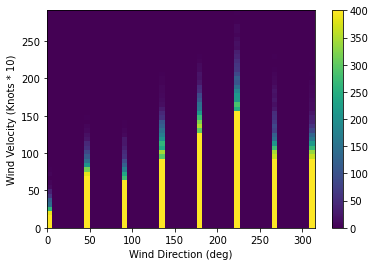

In [42]:
plt.hist2d(df['wind.bearing.mean'], df['wind.speed.mean'], bins = (50, 50), vmax = 400)
plt.colorbar()
plt.xlabel('Wind Direction (deg)')
plt.ylabel('Wind Velocity (Knots * 10)');

Convert wind direction and speed to _x_ and _y_ vectors, so the model can more easily interpret them.

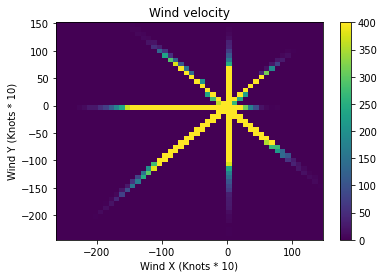

In [43]:
wv = df['wind.speed.mean']
max_wv = df['wind.speed.max']

# Convert to radians
wd_rad = df['wind.bearing.mean'] * np.pi / 180

# Calculate the wind x and y components
df['wind.x'] = wv * np.cos(wd_rad)
df['wind.y'] = wv * np.sin(wd_rad)

# Calculate the max wind x and y components
df['max.wind.x'] = max_wv * np.cos(wd_rad)
df['max.wind.y'] = max_wv * np.sin(wd_rad)

df_orig = df

plt.hist2d(df['wind.x'], df['wind.y'], bins = (50, 50), vmax = 400)
plt.colorbar()
plt.xlabel('Wind X (Knots * 10)')
plt.ylabel('Wind Y (Knots * 10)')
plt.title('Wind velocity');

Better, but not ideal.  Data augmentation with the 
[mixup](https://arxiv.org/abs/1710.09412) method is carried out at batch preparation time below.

From the paper:
"mixup trains a neural network on convex combinations of pairs of examples and their labels".

Further details on how I apply mixup to time series are included in the Window data section below.

Here is an illustration of the improvement in wind velocity with mixup augmentation.

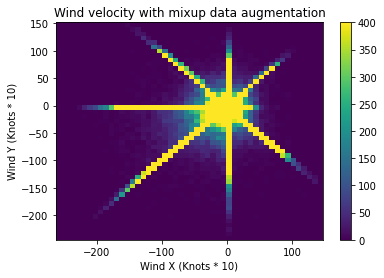

In [44]:
def mixup(data, alpha = 1.0, factor = 1):
    batch_size = len(data) - 1
    
    data['epoch'] = data.index.astype(np.int64) // 10**9
    
    # random sample lambda value from beta distribution
    l   = np.random.beta(alpha, alpha, batch_size * factor)
    X_l = l.reshape(batch_size * factor, 1)
    
    # Get a pair of inputs and outputs
    y1  = data['y'].shift(-1).dropna()
    y1_ = pd.concat([y1] * factor)
    
    y2  = data['y'][0:batch_size]
    y2_ = pd.concat([y2] * factor)

    X1  = data.drop('y', 1).shift(-1).dropna()
    X1_ = pd.concat([X1] * factor)
    
    X2  = data.drop('y', 1)
    X2  = X2[0:batch_size]
    X2_ = pd.concat([X2] * factor)

    # Perform mixup
    X = X1_ * X_l + X2_ * (1 - X_l)
    y = y1_ * l   + y2_ * (1 - l)    
    
    df = pd.DataFrame(y).join(X)    
    df = data.append(df).sort_values('epoch', ascending = True)
    df = df.drop('epoch', 1)
    
    df = df.drop_duplicates(keep=False)
    
    return df


df_mix = mixup(df.loc[:, ['y','wind.x','wind.y']], factor = 2)
plt.hist2d(df_mix['wind.x'], df_mix['wind.y'], bins = (50, 50), vmax = 400)
plt.colorbar()
plt.xlabel('Wind X (Knots * 10)')
plt.ylabel('Wind Y (Knots * 10)')
plt.title('Wind velocity with mixup data augmentation');

Mixup improves the categorical legacy of the wind velocity data.
Unfortunately, if outliers are present their influence will be reinforced.


### Missing value interpolation

Missing data is much less of a problem for [prophet models](https://github.com/makeyourownmaker/BayesianProphet)
which handle it seamlessly.

Currently there are around 8,000 missing observations in approx. 600 sections or "gaps".
The gaps range in length from 30 mins to 45 days.

Gaps have length across variables, i.e. if there is a gap of length 6 (3 hours) then all variables are missing for 6 consecutive observations.

Missing observations can be [imputed](https://en.wikipedia.org/wiki/Imputation_(statistics)).  
Here I use a variation on
[cubic interpolation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.PchipInterpolator.html).
Vanilla cubic interpolation overshoots the data which introduces outlier values.
I limit the gap length to 12 observations (6 hours).

Longer gaps will be accounted for at the train, test, validation split stage.

/usr/local/lib/python3.7/dist-packages/scipy/interpolate/_cubic.py:293: RuntimeWarning: invalid value encountered in add
  whmean = (w1/mk[:-1] + w2/mk[1:]) / (w1 + w2)


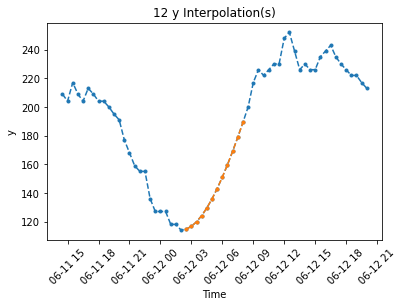

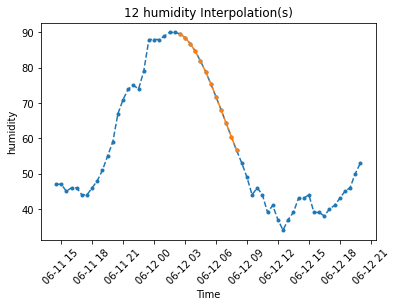

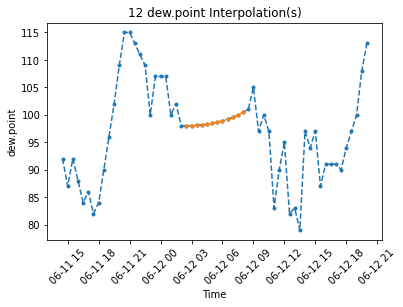

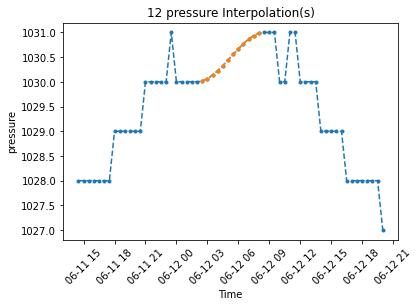

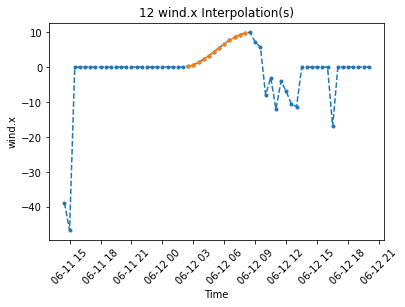

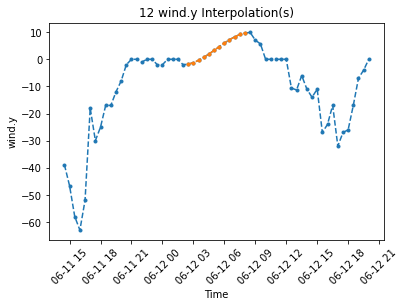

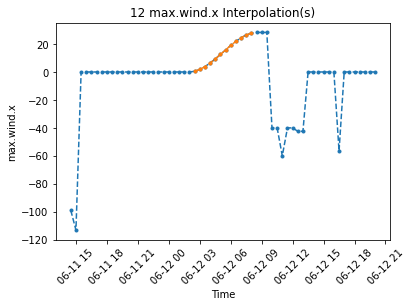

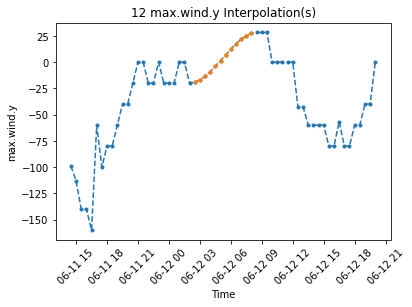

In [5]:
del_cols = ['doy', 'wind.bearing.mean', 'wind.speed.mean', 'wind.speed.max']
df_ts = df_orig.set_index('ds', drop = False)
df_ts.drop(del_cols, axis = 1, inplace = True)

# Add NaN values for missing observations
df_ts_na = df_ts.asfreq('30min')

# Set NaN year, time values using index
df_ts_na.ds   = df_ts_na.index
df_ts_na.year = df_ts_na.index.year
df_ts_na.time = df_ts_na.index.time

# Count number of consecutive missing values
#   There are more elegant ways to do this but they don't cope well with NaNs
#   As far as I can tell, neither numpy nor pandas have native run length encoding functions!?
len_holes = pd.Series([len(list(g)) for k, g in itertools.groupby(df_ts_na.y.isnull()) if k])
len_holes_long = pd.Series(list(itertools.repeat(l, l)) for l in len_holes)
len_holes_flat = pd.Series(list(itertools.chain(*len_holes_long)))

df_ts_na['missing_len'] = -100
df_ts_na['missing_len'] = df_ts_na['missing_len'].astype('Int64')
df_ts_na.loc[df_ts_na.y.isnull(), 'missing_len'] = len_holes_flat.to_numpy()

# Mark 24 observations before and after each group of NaNs - for plotting
df_ts_na['around_nan'] = -100
df_ts_na['around_nan'] = df_ts_na['around_nan'].astype('Int64')

for i in range(-24, 25):
    df_ts_na.loc[df_ts_na.y.isna().shift(i).fillna(False), 'around_nan'] = i
    
df_ts_na.loc[df_ts_na.y.isna(), 'around_nan'] = 0


# Interpolate - method = 'spline' very slow :-(
#               cubic and quadratic overshoot the data and introduce outliers
limit  = 12
method = 'pchip'
for v in ['y', 'humidity', 'dew.point', 'pressure', 'wind.x', 'wind.y', 'max.wind.x', 'max.wind.y']:
    df_ts_na[v] = df_ts_na[v].interpolate(method = method, limit = limit)


# Extract missing observations and surrounding values into dict of lists for checking & plotting
# gonna be slow :-(
j = miss_len = 0
inner_list = []
miss_plus  = {}
for index, row in df_ts_na.iterrows():
    if (row['around_nan'] > -25) | (row['missing_len'] > 0):
        inner_list.append(index)
        if row['missing_len'] > 0:
            miss_len = row['missing_len']
        j  = 1
    else:
        if j == 1:
            miss_plus.setdefault(miss_len, []).append(inner_list)
            inner_list = []
        j = miss_len = 0

#print("keys: ",  len(miss_plus.keys()))
#print("sum:  ",  sum(miss_plus.keys()))
#print("keys:  ", sorted(miss_plus.keys()))
#print(len(miss_plus[29]))
#print(len(miss_plus[29][0]))
#print(miss_plus[29][0])
#df_ts_na.loc[miss_plus[29][0]]        

def plot_interpolation(data, variable):
    marks = data.loc[data.missing_len > 0, variable]
    title = str(len(marks)) + ' ' + variable + ' Interpolation(s)'
    
    plt.figure()
    plt.plot(data[variable], marker = '.', linestyle = '--')
    plt.plot(marks, marker = '.', linestyle = '--')
    plt.xticks(rotation = 45)
    plt.title(title)
    plt.ylabel(variable)
    plt.xlabel('Time')

for v in ['y', 'humidity', 'dew.point', 'pressure', 'wind.x', 'wind.y', 'max.wind.x', 'max.wind.y']:
    plot_interpolation(df_ts_na.loc[miss_plus[12][1]], v)


# Remove gaps longer than 12
df_ts_na = df_ts_na.dropna()
drop_cols = ['missing_len', 'around_nan']
df_ts_na.drop(drop_cols, axis = 1, inplace = True)
df = df_ts_na

After all that, there is a 23 % reduction in missing values.

Alternative interpolation methods (piecewise methods in particular) may give more natural results for the wind and pressure variables.


### Time conversion

Convert `ds` timestamps to "time of day" and "time of year" variables using `sin` and `cos`.

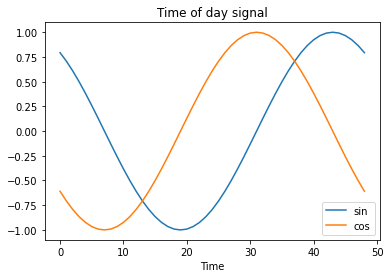

In [6]:
# Convert to secs
date_time   = pd.to_datetime(df['ds'], format = '%Y.%m.%d %H:%M:%S')
timestamp_s = date_time.map(datetime.datetime.timestamp)

day  = 24 * 60 * 60
year = (365.2425) * day

df['day.sin']  = np.sin(timestamp_s * (2 * np.pi / day))
df['day.cos']  = np.cos(timestamp_s * (2 * np.pi / day))
df['year.sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['year.cos'] = np.cos(timestamp_s * (2 * np.pi / year))

plt.plot(np.array(df['day.sin'])[:49])
plt.plot(np.array(df['day.cos'])[:49])
plt.xlabel('Time')
plt.legend(['sin', 'cos'], loc = 'lower right')
plt.title('Time of day signal');

### Split data

Use data from 2018 for validation and 2019 for testing.  These are entirely arbitrary choices.
This results in an approximate 82%, 9%, 9% split for the training, validation, and test sets.

In [7]:
keep_cols = ['y', 'humidity', 'dew.point', 'pressure', 'wind.x', 'wind.y',
             'day.sin', 'day.cos', 'year.sin', 'year.cos']
del_cols = ['ds', 'time', 'max.wind.x', 'max.wind.y']
df.drop(del_cols, axis = 1, inplace = True)

train_df = df.loc[(df['year'] != 2018) & (df['year'] != 2019)]
valid_df = df.loc[df['year'] == 2018]
test_df  = df.loc[df['year'] == 2019]

train_df = train_df.drop('year', axis = 1)  # inplace = True gives SettingWithCopyWarning
valid_df = valid_df.drop('year', axis = 1)  # ...
test_df  = test_df.drop('year',  axis = 1)
df       = df.drop('year',       axis = 1)

print("df.drop shape: ", df.shape)
print("train shape:   ", train_df.shape)
print("valid shape:   ", valid_df.shape)
print("test shape:    ", test_df.shape)

df.drop shape:  (194736, 10)
train shape:    (160059, 10)
valid shape:    (17236, 10)
test shape:     (17441, 10)


### Normalise data

Features should be scaled before neural network training.  Arguably, scaling should be done using moving averages to avoid accessing future values.  
Instead, simple [standard score](https://en.wikipedia.org/wiki/Standard_score) 
normalisation will be used.

Plot [violin plot](https://en.wikipedia.org/wiki/Violin_plot) 
to see distribution of features.

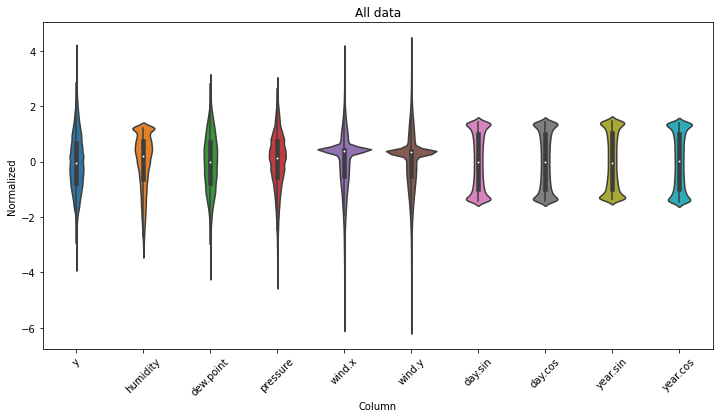

In [8]:
train_mean = train_df.mean()
train_std  = train_df.std()

train_df = (train_df - train_mean) / train_std
valid_df = (valid_df - train_mean) / train_std
test_df  = (test_df  - train_mean) / train_std

df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name = 'Column', value_name = 'Normalized')

plt.figure(figsize=(12, 6))
ax = sns.violinplot(x = 'Column', y = 'Normalized', data = df_std)
ax.set_xticklabels(df.keys(), rotation = 45)
ax.set_title('All data');

There may still be some outliers present but there are no glaring problems.


### Window data

Models are trained using sliding windows of samples from the data.

Window parameters to consider for the 
[tf.keras.preprocessing.timeseries_dataset_from_array](https://keras.io/api/preprocessing/timeseries/#timeseries-data-preprocessing)
function:
 * sequence_length: 
   * Length of the output sequences (in number of timesteps), or number of **lag** observations to use
 * sequence_stride: 
   * Period between successive output sequences.  For stride s, output samples start at index data[i], data[i + s], data[i + 2 * s] etc
   * s can include an **offset** and/or 1 or more **steps ahead** to forecast
 * batch_size: 
   * Number of samples in each batch
 * shuffle: 
   * Shuffle output samples, or use chronological order
 
Initial values used:
 * sequence_length (aka lags): 24
 * steps ahead (what to forecast): 1 and separately 4
 * offset (space between lags and steps ahead): 0
 * batch_size: 32
 * shuffle: True for train and validation data
 
The lags, batch_size and shuffle values may be optimised later.

The `make_dataset` function below generates [tensorflow datasets](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) for:
 * Lags, steps-ahead, offset, batch size and shuffle
 * Optionally multiple y columns (Not extensively tested)
 
Stride is used to specify offset + steps-ahead.  Offset will be 0 throughout this notebook.

**TODO** Insert figure illustrating lags, offsets and steps-ahead.

`shuffle = True` is used with train and validation data.
`shuffle = False` is used with test data so the residuals can be checked for heteroscadicity.

Throughout this notebook I use a shorthand notation to describe lags and strides.  For example:
 * 24l_1s is 24 lags 1 step ahead
 * 24l_4s is 24 lags 4 steps ahead

#### Mixup data augmentation

Data augmentation with the [mixup: Beyond Empirical Risk Minimization](https://arxiv.org/abs/1710.09412) by Zhang *et al* is used to help counter the categorical legacy from the wind bearing variable.  Simple 'input mixup' is used as opposed to the batch-based mixup Zhang *et al* focus on.  Input mixup has the advantage that it can be used with non-neural network methods such as [prophet](https://github.com/makeyourownmaker/BayesianProphet).  Mixup is performed for train and validation data separately.  With current settings these datasets are approximately 3 times larger but this can be varied.  Test data is left unmodified.

To the best of my knowledge mixup has not beeen used with time series before.
I apply mixup between consecutive observations in the time series instead of the usual random observations.  Applying mixup between inputs with equal temperature values will not improve performance and will increase run time.

In [12]:
def make_dataset(data, y_cols, lags = 1, steps_ahead = 1, stride = 1, bs = 32, shuffle = False, mix = 2):    
    assert stride >= steps_ahead

    total_window_size = lags + stride
    
    # Add NaN values for missing observations
    data = data.asfreq('30min')
    
    # Split data into subsets (blocks) on NaNs - SLOW - https://stackoverflow.com/a/21404655/100129
    blocks = np.split(data, np.where(np.isnan(data.y))[0])
    # removing NaN entries
    blocks = [bl[~np.isnan(bl.y)] for bl in blocks if not isinstance(bl, np.ndarray)]
    # removing empty DataFrames
    blocks = [bl for bl in blocks if not bl.empty]
    
    i = 0    
    for block in blocks:
        i += 1
        if mix != 0:
            block_mix = mixup(block, factor = mix)
        else:
            block_mix = block
        block_np  = np.array(block_mix, dtype = np.float32)
        
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
               data    = block_np,
               targets = None,
               sequence_length = total_window_size,
               sequence_stride = 1,
               shuffle    = shuffle,
               batch_size = bs)
            
        col_indices = {name: i for i, name in enumerate(data.columns)}    
        X_slice = slice(0, lags)
        y_start = total_window_size - steps_ahead
        y_slice = slice(y_start, None)

    
        def split_window(features):   
            X = features[:, X_slice, :]
            y = features[:, y_slice, :]

            X = tf.stack(
                [X[:, :, col_indices[name]] for name in data.columns],
                axis = -1)    
            y = tf.stack(
                [y[:, :, col_indices[name]] for name in y_cols],
                axis = -1)

            # Slicing doesn't preserve static shape information, so set the shapes manually.
            # This way the `tf.data.Datasets` are easier to inspect.
            X.set_shape([None, lags,        None])
            y.set_shape([None, steps_ahead, None])

            return X, y

    
        ds = ds.map(split_window)
        
        if i == 1:
            combined_dataset = ds
        else:
            combined_dataset = combined_dataset.concatenate(ds)
        
    return combined_dataset


def make_datasets(train, valid, test, 
                  y_cols = 'y', lags = 1, steps_ahead = 1, 
                  stride = 1, bs = 32, shuffle = False):
    ds_train = make_dataset(train, y_cols, 
                            lags = lags, steps_ahead = steps_ahead, 
                            stride = stride, shuffle = shuffle)
    ds_valid = make_dataset(valid, y_cols, 
                            lags = lags, steps_ahead = steps_ahead, 
                            stride = stride, shuffle = shuffle)
    ds_test  = make_dataset(test,  y_cols, 
                            lags = lags, steps_ahead = steps_ahead, 
                            stride = stride, shuffle = False, mix = 0)
    
    return ds_train, ds_valid, ds_test


def dataset_sanity_checks(data, name):    
    print(name, "batches: ", data.cardinality().numpy())
    for batch in data.take(1):
        print("\tX (batch_size, time, features): ", batch[0].shape)
        print("\ty (batch_size, time, features): ", batch[1].shape)
        print("\tX[0][0]: ", batch[0][0])
        print("\ty[0][0]: ", batch[1][0])
    

# Single step-ahead
bs = 32
shuffle = True
ds_train_24l_1s, ds_valid_24l_1s, ds_test_24l_1s = make_datasets(train_df, valid_df, test_df, 
                                                                 lags = 24, shuffle = shuffle, bs = bs)
# dataset_sanity_checks(ds_train_4l_1s, '4l 1s train');


# 4 steps-ahead
steps = stride = 4
ds_train_24l_4s, ds_valid_24l_4s, ds_test_24l_4s = make_datasets(train_df, valid_df, test_df, 
                                                                 lags = 24, steps_ahead = steps, 
                                                                 stride = stride, shuffle = shuffle, bs = bs)

# lags = 4
# display(train_df.head(lags + steps))
# dataset_sanity_checks(ds_train_4l_4s, '4l 4s train');

---


## Model Building

Model architectures considered:
 * MLP
 * [FCN](https://arxiv.org/abs/1611.06455)
 * ResNet
 
The architectures considered were inspired by those used by Wang *et al* in 
[Time Series Classification from Scratch with Deep
Neural Networks: A Strong Baseline](https://arxiv.org/abs/1611.06455).
Initial hyperparameter settings came from 
[Deep learning for time series classification: a review](https://link.springer.com/article/10.1007%2Fs10618-019-00619-1).

I'm primarily interested in "now-casting" or forecasting in the next 1 or 2 hours.
The following model outputs are investigated:
 * Single step ahead - 30 mins
 * Multi-step ahead - 30, 60, 90 and 120 mins

The training and validation code are stored in the `compile_fit_validate` function below.


### Multi-layer perceptron

It is useful to check the performance of the multi-layer perceptron (MLP) before using more sophisticated models.
The MLP is described in the `build_mlp_model` function below.  It deviates from the Wang *et al*/Fawaz *et al* model.
Specifically, I use a `Flatten` layer for the first layer to train on multiple input lags.

First, check single step-ahead predictions.

Model: "MLP"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 240)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                15424     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
_________________________________________________________________
reshape (Reshape)            (None, 1, 1)              0         
Total params: 19,649
Trainable params: 19,649
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
18914/18914 - 64s - loss: 0.0066 - mae: 0.0545 - mape: 26.9018 - val_loss: 0.0029 - val_mae: 0.0406 - val_mape: 20

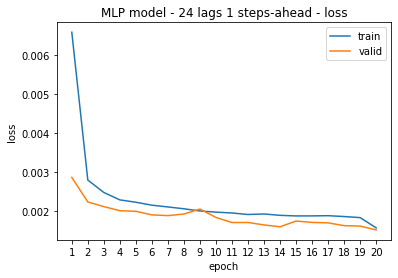

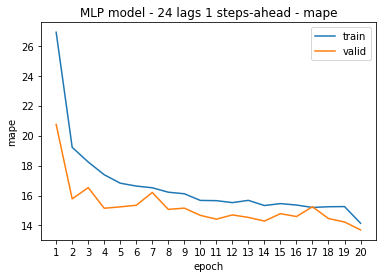

MLP model - 24 lags 1 steps-ahead - train min loss: 0.001578	mae: 0.025440	mape: 14.150303	epoch: 20
MLP model - 24 lags 1 steps-ahead - valid min loss: 0.001525	mae: 0.025086	mape: 13.702776	epoch: 20



In [13]:
def compile_fit_validate(model, train, valid, optimizer, epochs = 5, verbose = 2):
    # Reduces variance in results but won't eliminate it :-(
    random.seed(42)
    np.random.seed(42)
    tf.random.set_seed(42)
    
    if optimizer.lower() == 'adadelta':
        opt = Adadelta(lr = 1.0)
    else:
        opt = Adam(lr = 0.001)
        
    es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 10)
    lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 5, min_lr = 0.0001)

    model.compile(optimizer = opt, loss = 'mse', metrics = ['mae', 'mape'])    
    h = model.fit(train, validation_data = valid,
                  epochs = epochs, verbose = verbose, callbacks = [es, lr])
    
    return h

    
def plot_history(h, name, epochs = 10):
    plt.plot(h.history['loss'])
    plt.plot(h.history['val_loss'])
    plt.xticks(range(0, epochs), labels = range(1, epochs + 1))
    plt.title(name + ' loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc = 'upper right')
    plt.show()

    plt.plot(h.history['mape'])
    plt.plot(h.history['val_mape'])
    plt.xticks(range(0, epochs), labels = range(1, epochs + 1))
    plt.title(name + ' mape')
    plt.ylabel('mape')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc = 'upper right')
    plt.show();

    
def print_min_loss(h, name):
    argmin_loss     = np.argmin(np.array(h.history['loss']))
    argmin_val_loss = np.argmin(np.array(h.history['val_loss']))
    min_loss        = h.history['loss'][argmin_loss]
    min_val_loss    = h.history['val_loss'][argmin_val_loss]
    mape            = h.history['mape'][argmin_loss]
    val_mape        = h.history['val_mape'][argmin_val_loss]
    mae             = h.history['mae'][argmin_loss]
    val_mae         = h.history['val_mae'][argmin_val_loss]
    
    txt = "{0:s} {1:s} min loss: {2:f}\tmae: {3:f}\tmape: {4:f}\tepoch: {5:d}"
    print(txt.format(name, "train", min_loss,     mae,     mape,     argmin_loss + 1))
    print(txt.format(name, "valid", min_val_loss, val_mae, val_mape, argmin_val_loss + 1))
    print()


def get_io_shapes(data):
    for batch in data.take(1):
        in_shape  = batch[0][0].shape
        out_shape = batch[1][0].shape
        
    return in_shape, out_shape


def build_mlp_model(name, data, neurons = 64):
    in_shape, out_shape = get_io_shapes(data)
    out_steps = out_shape[0]
    
    mlp = Sequential(name = name)
    
    mlp.add(Input(shape = in_shape))
    mlp.add(Flatten())  # Shape: (time, features) => (time*features)
    # mlp.add(Dropout(0.1))
    
    mlp.add(Dense(neurons, activation = 'relu'))
    # mlp.add(Dropout(0.1))
    
    mlp.add(Dense(neurons, activation = 'relu'))
    # mlp.add(Dropout(0.1))
    
    mlp.add(Dense(out_steps))   
    mlp.add(Reshape([1, -1]))
    
    return mlp


def run_model(model, train, valid, optimizer = 'adam', epochs = 5):
    in_shape, out_shape = get_io_shapes(train)
    model_id = model.name + ' model - ' + str(in_shape[0]) + \
               ' lags ' + str(out_shape[0]) + ' steps-ahead -'
    
    model.summary()
    h = compile_fit_validate(model, train, valid, optimizer, epochs)
    plot_history(h, model_id, epochs)
    print_min_loss(h, model_id)
    
    return h

 
name = 'MLP'
mlp_24l_1s   = build_mlp_model(name, ds_train_24l_1s)
h_mlp_24l_1s = run_model(mlp_24l_1s, ds_train_24l_1s, ds_valid_24l_1s, optimizer = 'adadelta', epochs = 20)

Second, check multiple time-steps.

Model: "MLP"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_5 (Flatten)          (None, 240)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 64)                15424     
_________________________________________________________________
dense_16 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_17 (Dense)             (None, 4)                 260       
_________________________________________________________________
reshape_4 (Reshape)          (None, 1, 4)              0         
Total params: 19,844
Trainable params: 19,844
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
18898/18898 - 66s - loss: 0.0075 - mae: 0.0612 - mape: 47.1148 - val_loss: 0.0041 - val_mae: 0.0454 - val_mape: 24

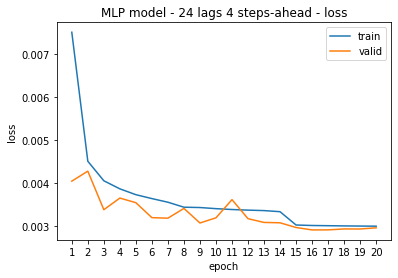

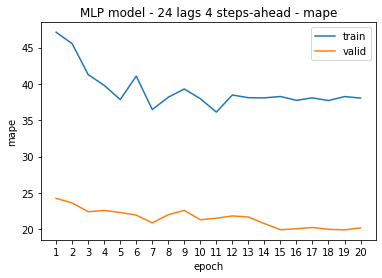

MLP model - 24 lags 4 steps-ahead - train min loss: 0.003007	mae: 0.037378	mape: 38.043709	epoch: 20
MLP model - 24 lags 4 steps-ahead - valid min loss: 0.002920	mae: 0.037096	mape: 20.058220	epoch: 16



In [33]:
mlp_24l_4s   = build_mlp_model(name, ds_train_24l_4s)
h_mlp_24l_4s = run_model(mlp_24l_4s, ds_train_24l_4s, ds_valid_24l_4s, optimizer = 'adadelta', epochs = 20)

### Fully convolutional network

See [Time Series Classification from Scratch with Deep Neural Networks: A Strong Baseline](https://arxiv.org/abs/1611.06455)
for a detailed description of the Fully Convolutional Network (FCN) architecture.  The FCN
was first described in
[Time-series modeling with undecimated fully convolutional neural networks](https://arxiv.org/abs/1508.00317).

The FCN architecture is a variant of the Convolutional Neural Network (CNN).  A Convolutional 
Neural Network (CNN) usually contains fully-connected layers or a MLP at the 
end of the network.  The FCN does not include these final layers, so it is learning 
convolutional filters everywhere.

**TODO** Include figure comparing FCNs and CNNs

The Keras [Conv1D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv1D)
layer is used for temporal convolution.

First, check single step-ahead predictions.

Model: "FCN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1, 64)             5184      
_________________________________________________________________
batch_normalization (BatchNo (None, 1, 64)             256       
_________________________________________________________________
activation (Activation)      (None, 1, 64)             0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1, 64)             20544     
_________________________________________________________________
batch_normalization_1 (Batch (None, 1, 64)             256       
_________________________________________________________________
activation_1 (Activation)    (None, 1, 64)             0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1, 64)             12352   

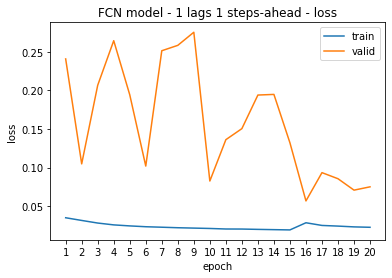

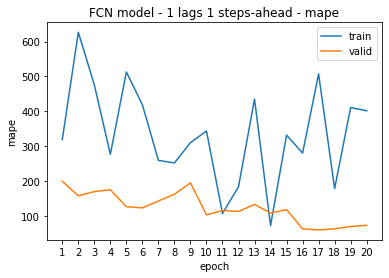

FCN model - 1 lags 1 steps-ahead - train min loss: 0.019073	mae: 0.098395	mape: 331.644531	epoch: 15
FCN model - 1 lags 1 steps-ahead - valid min loss: 0.056690	mae: 0.168071	mape: 62.374516	epoch: 16

Model: "FCN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 4, 64)             5184      
_________________________________________________________________
batch_normalization_3 (Batch (None, 4, 64)             256       
_________________________________________________________________
activation_3 (Activation)    (None, 4, 64)             0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 4, 64)             20544     
_________________________________________________________________
batch_normalization_4 (Batch (None, 4, 64)             256       
___________________________________________________________

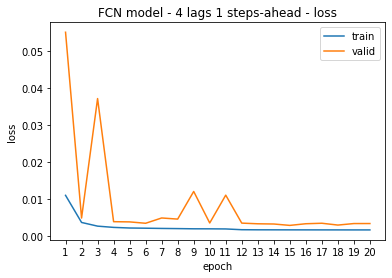

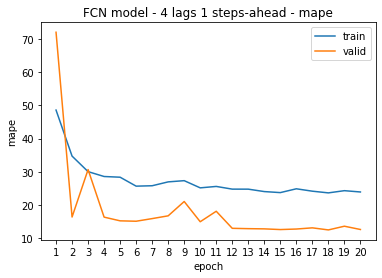

FCN model - 4 lags 1 steps-ahead - train min loss: 0.001727	mae: 0.026722	mape: 24.307241	epoch: 19
FCN model - 4 lags 1 steps-ahead - valid min loss: 0.002949	mae: 0.040550	mape: 12.589982	epoch: 15

Model: "FCN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_6 (Conv1D)            (None, 8, 64)             5184      
_________________________________________________________________
batch_normalization_6 (Batch (None, 8, 64)             256       
_________________________________________________________________
activation_6 (Activation)    (None, 8, 64)             0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 8, 64)             20544     
_________________________________________________________________
batch_normalization_7 (Batch (None, 8, 64)             256       
____________________________________________________________

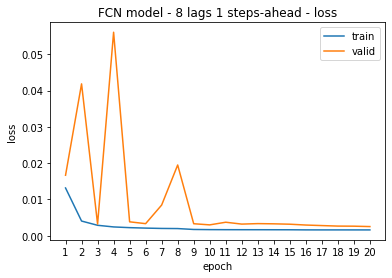

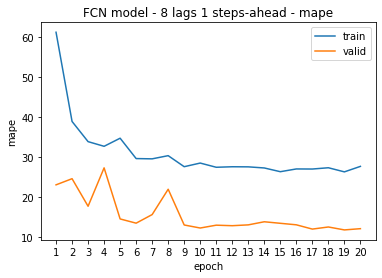

FCN model - 8 lags 1 steps-ahead - train min loss: 0.001604	mae: 0.025680	mape: 27.702356	epoch: 20
FCN model - 8 lags 1 steps-ahead - valid min loss: 0.002526	mae: 0.037700	mape: 12.106796	epoch: 20

Model: "FCN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_9 (Conv1D)            (None, 16, 64)            5184      
_________________________________________________________________
batch_normalization_9 (Batch (None, 16, 64)            256       
_________________________________________________________________
activation_9 (Activation)    (None, 16, 64)            0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 16, 64)            20544     
_________________________________________________________________
batch_normalization_10 (Batc (None, 16, 64)            256       
____________________________________________________________

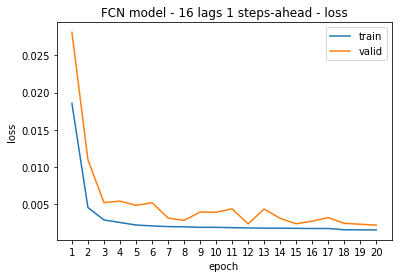

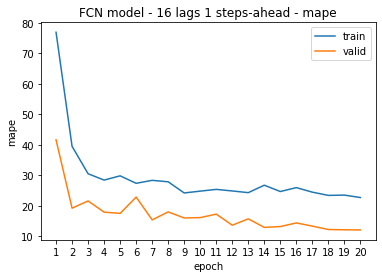

FCN model - 16 lags 1 steps-ahead - train min loss: 0.001594	mae: 0.025728	mape: 22.716648	epoch: 20
FCN model - 16 lags 1 steps-ahead - valid min loss: 0.002240	mae: 0.034602	mape: 12.087583	epoch: 20

Model: "FCN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_12 (Conv1D)           (None, 24, 64)            5184      
_________________________________________________________________
batch_normalization_12 (Batc (None, 24, 64)            256       
_________________________________________________________________
activation_12 (Activation)   (None, 24, 64)            0         
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 24, 64)            20544     
_________________________________________________________________
batch_normalization_13 (Batc (None, 24, 64)            256       
__________________________________________________________

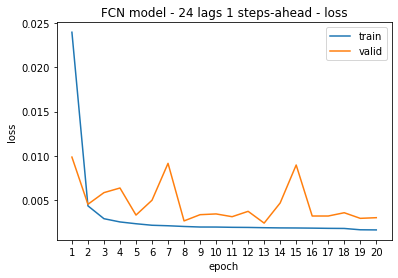

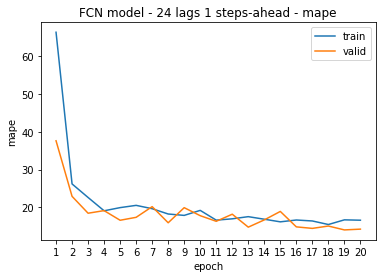

FCN model - 24 lags 1 steps-ahead - train min loss: 0.001616	mae: 0.025862	mape: 16.601654	epoch: 20
FCN model - 24 lags 1 steps-ahead - valid min loss: 0.002386	mae: 0.035417	mape: 14.770091	epoch: 13

Model: "FCN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_15 (Conv1D)           (None, 32, 64)            5184      
_________________________________________________________________
batch_normalization_15 (Batc (None, 32, 64)            256       
_________________________________________________________________
activation_15 (Activation)   (None, 32, 64)            0         
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 32, 64)            20544     
_________________________________________________________________
batch_normalization_16 (Batc (None, 32, 64)            256       
__________________________________________________________

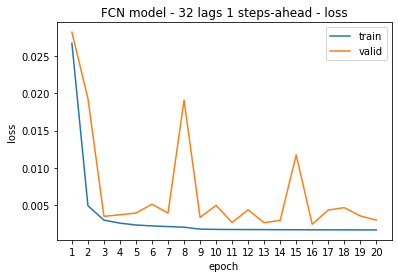

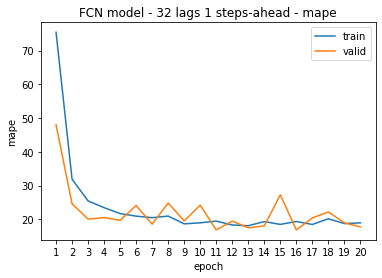

FCN model - 32 lags 1 steps-ahead - train min loss: 0.001658	mae: 0.026391	mape: 18.956280	epoch: 20
FCN model - 32 lags 1 steps-ahead - valid min loss: 0.002416	mae: 0.035491	mape: 16.856560	epoch: 16

Model: "FCN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_18 (Conv1D)           (None, 40, 64)            5184      
_________________________________________________________________
batch_normalization_18 (Batc (None, 40, 64)            256       
_________________________________________________________________
activation_18 (Activation)   (None, 40, 64)            0         
_________________________________________________________________
conv1d_19 (Conv1D)           (None, 40, 64)            20544     
_________________________________________________________________
batch_normalization_19 (Batc (None, 40, 64)            256       
__________________________________________________________

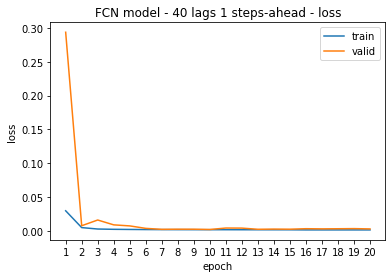

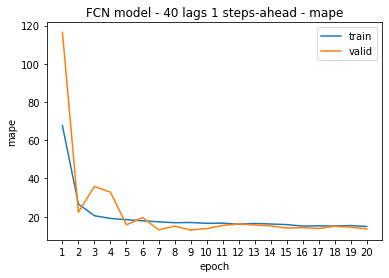

FCN model - 40 lags 1 steps-ahead - train min loss: 0.001607	mae: 0.025818	mape: 14.883586	epoch: 20
FCN model - 40 lags 1 steps-ahead - valid min loss: 0.002256	mae: 0.034137	mape: 13.740940	epoch: 10

Model: "FCN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_21 (Conv1D)           (None, 48, 64)            5184      
_________________________________________________________________
batch_normalization_21 (Batc (None, 48, 64)            256       
_________________________________________________________________
activation_21 (Activation)   (None, 48, 64)            0         
_________________________________________________________________
conv1d_22 (Conv1D)           (None, 48, 64)            20544     
_________________________________________________________________
batch_normalization_22 (Batc (None, 48, 64)            256       
__________________________________________________________

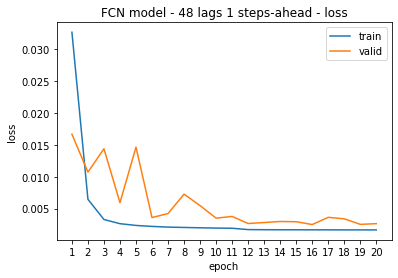

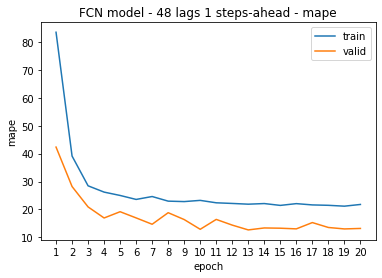

FCN model - 48 lags 1 steps-ahead - train min loss: 0.001653	mae: 0.026272	mape: 21.775749	epoch: 20
FCN model - 48 lags 1 steps-ahead - valid min loss: 0.002496	mae: 0.036218	mape: 13.027389	epoch: 16



In [11]:
def build_fcn_model(name, data, n_feature_maps = 64):
    in_shape, out_shape = get_io_shapes(data)
    out_steps = out_shape[0]
    
    fcn = Sequential(name = name)
    fcn.add(Input(shape = in_shape))
    
    fcn.add(Conv1D(filters = n_feature_maps, kernel_size = 8, padding = 'same'))
    fcn.add(BatchNormalization())
    fcn.add(Activation(activation = 'relu'))

    fcn.add(Conv1D(filters = n_feature_maps, kernel_size = 5, padding = 'same'))
    fcn.add(BatchNormalization())
    fcn.add(Activation(activation = 'relu'))

    fcn.add(Conv1D(filters = n_feature_maps, kernel_size = 3, padding = 'same'))
    fcn.add(BatchNormalization())
    fcn.add(Activation(activation = 'relu'))

    fcn.add(GlobalAveragePooling1D())
    fcn.add(Dense(out_shape))

    return fcn


name = 'FCN'
fcn_24l_1s   = build_fcn_model(name, ds_train_24l_1s)
h_fcn_24l_1s = run_model(fcn_24l_1s, ds_train_24l_1s, ds_valid_24l_1s, epochs = 20)

Second, check multiple step-ahead predictions.

In [ ]:
fcn_24l_4s   = build_fcn_model(name, ds_train_24l_1s)
h_fcn_24l_4s = run_model(fcn_24l_1s, ds_train_24l_1s, ds_valid_24l_1s, epochs = 20)

### Residual network

Residual networks, or ResNets, were originally proposed in
[Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385).

Residual neural networks use "identity shortcut connections" to skip over some layers.  Typical ResNet models are implemented with blocks of layers that contain nonlinearities (ReLU) and batch normalization.
Skipping over layers may avoid the problem of vanishing gradients, by reusing activations from a previous layer until the adjacent layer learns its weights.  This should allow training networks with more layers.

**TODO** Include basic ResNet diagram

Again, the Keras [Conv1D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv1D)
layer is used for temporal convolution.

First, check single step-ahead predictions.

Model: "ResNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           [(None, 4, 10)]      0                                            
__________________________________________________________________________________________________
conv1d_24 (Conv1D)              (None, 4, 64)        5184        input_17[0][0]                   
__________________________________________________________________________________________________
batch_normalization_24 (BatchNo (None, 4, 64)        256         conv1d_24[0][0]                  
__________________________________________________________________________________________________
activation_24 (Activation)      (None, 4, 64)        0           batch_normalization_24[0][0]     
_____________________________________________________________________________________________

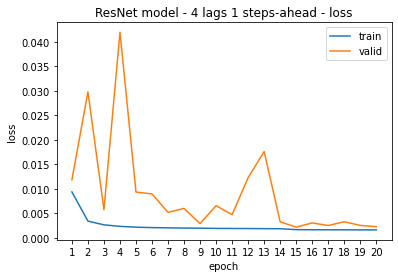

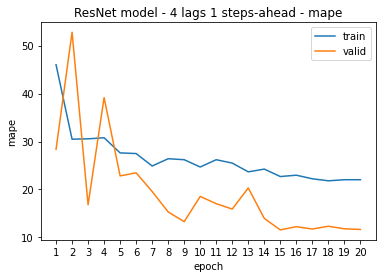

ResNet model - 4 lags 1 steps-ahead - train min loss: 0.001629	mae: 0.025905	mape: 22.040712	epoch: 20
ResNet model - 4 lags 1 steps-ahead - valid min loss: 0.002194	mae: 0.033755	mape: 11.570963	epoch: 15

Model: "ResNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_18 (InputLayer)           [(None, 8, 10)]      0                                            
__________________________________________________________________________________________________
conv1d_35 (Conv1D)              (None, 8, 64)        5184        input_18[0][0]                   
__________________________________________________________________________________________________
batch_normalization_36 (BatchNo (None, 8, 64)        256         conv1d_35[0][0]                  
____________________________________________________________________________________

In [ ]:
 def build_resnet_model(name, data, n_feature_maps = 64):
    in_shape, out_shape = get_io_shapes(data)
    out_steps = out_shape[0]
        
    input_layer = keras.layers.Input(in_shape)
    
    # BLOCK 1
    conv_x = keras.layers.Conv1D(filters = n_feature_maps, kernel_size = 8, padding = 'same')(input_layer)
    conv_x = keras.layers.BatchNormalization()(conv_x)
    conv_x = keras.layers.Activation('relu')(conv_x)

    conv_y = keras.layers.Conv1D(filters = n_feature_maps, kernel_size = 5, padding = 'same')(conv_x)
    conv_y = keras.layers.BatchNormalization()(conv_y)
    conv_y = keras.layers.Activation('relu')(conv_y)

    conv_z = keras.layers.Conv1D(filters = n_feature_maps, kernel_size = 3, padding='same')(conv_y)
    conv_z = keras.layers.BatchNormalization()(conv_z)

    # expand channels for the sum
    shortcut_y = keras.layers.Conv1D(filters = n_feature_maps, kernel_size = 1, padding = 'same')(input_layer)
    shortcut_y = keras.layers.BatchNormalization()(shortcut_y)

    output_block_1 = keras.layers.add([shortcut_y, conv_z])
    output_block_1 = keras.layers.Activation('relu')(output_block_1)

        
    # BLOCK 2
    conv_x = keras.layers.Conv1D(filters = n_feature_maps * 2, kernel_size = 8, padding = 'same')(output_block_1)
    conv_x = keras.layers.BatchNormalization()(conv_x)
    conv_x = keras.layers.Activation('relu')(conv_x)

    conv_y = keras.layers.Conv1D(filters = n_feature_maps * 2, kernel_size = 5, padding = 'same')(conv_x)
    conv_y = keras.layers.BatchNormalization()(conv_y)
    conv_y = keras.layers.Activation('relu')(conv_y)

    conv_z = keras.layers.Conv1D(filters = n_feature_maps * 2, kernel_size = 3, padding = 'same')(conv_y)
    conv_z = keras.layers.BatchNormalization()(conv_z)

    # expand channels for the sum
    shortcut_y = keras.layers.Conv1D(filters = n_feature_maps * 2, kernel_size = 1, padding = 'same')(output_block_1)
    shortcut_y = keras.layers.BatchNormalization()(shortcut_y)

    output_block_2 = keras.layers.add([shortcut_y, conv_z])
    output_block_2 = keras.layers.Activation('relu')(output_block_2)

        
    # BLOCK 3
    conv_x = keras.layers.Conv1D(filters = n_feature_maps * 2, kernel_size = 8, padding = 'same')(output_block_2)
    conv_x = keras.layers.BatchNormalization()(conv_x)
    conv_x = keras.layers.Activation('relu')(conv_x)

    conv_y = keras.layers.Conv1D(filters = n_feature_maps * 2, kernel_size = 5, padding = 'same')(conv_x)
    conv_y = keras.layers.BatchNormalization()(conv_y)
    conv_y = keras.layers.Activation('relu')(conv_y)

    conv_z = keras.layers.Conv1D(filters = n_feature_maps * 2, kernel_size = 3, padding = 'same')(conv_y)
    conv_z = keras.layers.BatchNormalization()(conv_z)

    # no need to expand channels because they are equal
    shortcut_y = keras.layers.BatchNormalization()(output_block_2)

    output_block_3 = keras.layers.add([shortcut_y, conv_z])
    output_block_3 = keras.layers.Activation('relu')(output_block_3)

    # FINAL
    gap_layer = keras.layers.GlobalAveragePooling1D()(output_block_3)
    output_layer = keras.layers.Dense(out_steps)(gap_layer)
    resnet = keras.models.Model(name = name, inputs = input_layer, outputs = output_layer)

    return resnet
   

name = 'ResNet'
resnet_24l_1s   = build_resnet_model(name, ds_train_24l_1s)
h_resnet_24l_1s = run_model(resnet_24l_1s, ds_train_24l_1s, ds_valid_24l_1s, epochs = 20)

Second, check multiple step-ahead predictions.

In [ ]:
resnet_24l_4s   = build_resnet_model(name, ds_train_24l_4s)
h_resnet_24l_4s = run_model(resnet_24l_4s, ds_train_24l_4s, ds_valid_24l_4s, epochs = 20)

### Architecture comparison/test data results

All 3 architectures gave similar results.
None of the architectures were heavily optimised.

**TODO** Insert architecture comparison table

Here I assume the unoptimised FCN and ResNet models are over-parameterised and check the MLP models on the test data.  

The test data covers all of 2019.  I check the 1 step ahead and the 4 steps ahead forecasts on the inverse transformed data (temperature in C) using two plots:
 * predicted vs observed
 * residuals vs time

Plus two summary values:
 * root mean square error
 * median absolute error

t rmse 24l 1s: 7.5919724
t mae 24l 1s:  4.1160583


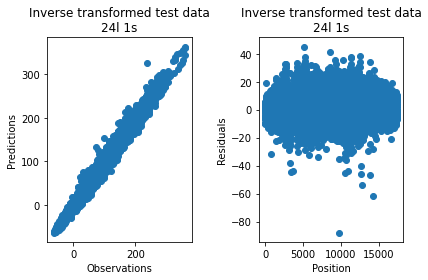

t rmse 24l 4s: 14.272273
t mae 24l 4s:  6.9250336


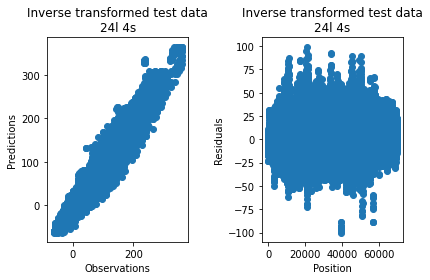

In [51]:
def plot_obs_preds(obs, preds, title):
    plt.subplot(1, 2, 1)
    plt.scatter(x = obs, y = preds)
    plt.xlabel('Observations')
    plt.ylabel('Predictions')
    plt.title(title)


def plot_residuals(obs, preds, title):
    plt.subplot(1, 2, 2)
    plt.scatter(x = range(len(obs)), y = (obs - preds))
    plt.xlabel('Position')
    plt.ylabel('Residuals')
    plt.title(title)
    plt.tight_layout()
    plt.show()


def rmse(obs, preds):
    return np.sqrt(np.mean((obs - preds) ** 2))


def mae(obs, preds):
    return np.median(np.abs(obs - preds))


def check_test_data(model, test, desc):
    preds = model.predict(test)
    obs   = np.concatenate([y for _, y in test], axis = 0)

    # reshape obs & preds
    label_len = obs.shape[0]
    preds_len = len(preds)
    assert label_len == preds_len

    preds_long = preds.reshape((obs.shape[0] * obs.shape[1]))
    test_long  = obs.reshape((obs.shape[0] * obs.shape[1]))

    # inverse transform using train mean & sd
    y_train_mean = train_mean[0]
    y_train_std  = train_std[0]

    t_preds = preds_long * y_train_std + y_train_mean
    t_obs   =  test_long * y_train_std + y_train_mean

    t_rmse = rmse(t_obs, t_preds)
    t_mae  =  mae(t_obs, t_preds)
    print("t rmse ", desc, ": ",  t_rmse, sep = '')
    print("t mae ",  desc, ":  ", t_mae,  sep = '')

    title = 'Inverse transformed test data\n' + desc
    plot_obs_preds(t_obs, t_preds, title)
    plot_residuals(t_obs, t_preds, title)


check_test_data(mlp_24l_1s, ds_test_24l_1s, '24l 1s')
check_test_data(mlp_24l_4s, ds_test_24l_4s, '24l 4s') # TODO Treat 4 step ahead properly


From the plots, its worth noting:
 * there is good agreement between observations and predictions
 * observations are relatively sparse above 30 C
 * as expected 4 step ahead predictions are worse than 1 step ahead
 * there may be a little heteroscadicity in the residuals
 * there is at least one obvious outlier


---


## Conclusion

Unfortunately, the root mean square error and mean absolute error values from the unaugmented test data do not improve on the [baseline methods](https://github.com/makeyourownmaker/CambridgeTemperatureModel) or my earlier [prophet model](https://github.com/makeyourownmaker/BayesianProphet/).

On an unrelated matter, validation loss values below training loss values indicate problems with validation data.  This may be due to redundancy between training and validation data sets.

Future work:
 * examine using simple exponential smoothing for interpolation
 * optimise mixup
   * optimise amount of mixup and mixup parameters
   * switch to mini-batch mixup
   * more care may need to be applied when removing outliers
   * test time augmentation using mixup may prove beneficial 
 * optimise architectures with [keras-tuner](https://github.com/keras-team/keras-tuner)
 * decorrelate input variables
   * deseasonalise (daily & annual) pressure, humidity, wind etc
 * move some code to module(s) for reuse
   * particularly data prep

---

## Metadata

Python and Jupyter versions plus modules imported and their version strings. 
This is the poor man's python equivalent of R's sessionInfo().

Code for imported modules and versions adapted from this stackoverflow answer. 
There are simpler alternatives, such as watermark, but they all require installation.

In [ ]:
import sys
import IPython

print("Python version:")
print(sys.executable)
print(sys.version)
print("\nIPython version:")
print(IPython.__version__)

In [ ]:
import pkg_resources
import types

def get_imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            # Split ensures you get root package, 
            # not just imported function
            name = val.__name__.split(".")[0]

        elif isinstance(val, type):
            name = val.__module__.split(".")[0]

        # Some packages are weird and have different
        # imported names vs. system/pip names.  Unfortunately,
        # there is no systematic way to get pip names from
        # a package's imported name.  You'll have to add
        # exceptions to this list manually!
        poorly_named_packages = {
            "PIL":       "Pillow",
            "sklearn":   "scikit-learn",
        }
        if name in poorly_named_packages.keys():
            name = poorly_named_packages[name]

        yield name

imports = list(set(get_imports()))

# The only way I found to get the version of the root package
# from only the name of the package is to cross-check the names 
# of installed packages vs. imported packages
requirements = []
for m in pkg_resources.working_set:
    if m.project_name in imports and m.project_name != "pip":
        requirements.append((m.project_name, m.version))

reqs = pd.DataFrame(requirements, columns = ['name', 'version'])
print("Imported modules:")
reqs.style.hide_index()

In [ ]:
!date

---


## Archival

Archive code, markdown, history and formatted notebooks.

Assumes all pdf, html, latex etc dependencies are installed.

**WARNING** Will overwrite existing files.

Notebook name is hardcoded below because the alternative is ghastly globs of unreliable javascript or external ipython libraries I'd prefer to avoid installing :-(

In [ ]:
from time import sleep

notebook = "keras_mlp_fcn_resnet_time_series.ipynb"
# !jupyter nbconvert --to script {notebook}
# !jupyter nbconvert --execute --to html {notebook}
# !jupyter nbconvert --execute --to pdf {notebook}
# !jupyter nbconvert --to pdf {notebook}

%rm history.txt
%history -f history.txt

!jupyter nbconvert --to python {notebook}
sleep(5)
!jupyter nbconvert --to markdown {notebook}
sleep(5)
!jupyter nbconvert --to html {notebook}